In [2]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import matplotlib
import pickle
import time

matplotlib.use('Agg')
%matplotlib inline

In [3]:
filename = [["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]]


def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return np.array(mnist["training_images"]), np.array(mnist["training_labels"]), np.array(mnist["test_images"]), np.array(mnist["test_labels"])

def create_grid_image(N, nodes, resolution=8):
    map_image = np.zeros((N*28, N*28))
    som_node_grid = nodes.reshape(N, N, -1)
    for i, row in enumerate(som_node_grid):
        for j, unit in enumerate(row):
            map_image[i * 28:(i + 1)*28, j*28:(j+1)*28] = unit.reshape(28,28)
    return map_image



In [4]:
class SOM():
    def __init__(self, teachers, N, seed=None):
        self.teachers = np.array(teachers)
        self.n_teacher = self.teachers.shape[0]
        self.N = N
        if not seed is None:
            np.random.seed(seed)
            
        x, y = np.meshgrid(range(self.N), range(self.N))
        self.c = np.hstack((x.flatten()[:, np.newaxis],
                            y.flatten()[:, np.newaxis]))
        self.nodes = np.random.rand(self.N * self.N, self.teachers.shape[1])
    
    def train(self):
        for i, teacher in enumerate(self.teachers):
            bmu = self._best_matching_unit(teacher)
            d = np.linalg.norm(self.c - bmu, axis=1)
            L = self._learning_ratio(i)
            S = self._learning_radius(i, d)
            self.nodes += L * S[:, np.newaxis] * (teacher - self.nodes)
        return self.nodes

    def _best_matching_unit(self, teacher):
        #compute all norms (square)
        norms = np.linalg.norm(self.nodes - teacher, axis=1)
        bmu = np.argmin(norms) #argment with minimum element 
        return np.unravel_index(bmu,(self.N, self.N))

    def _neighbourhood(self, t):#neighbourhood radious
        halflife = float(self.n_teacher / 4.) #for testing
        initial  = float(self.N / 2.)
        return initial*np.exp(-t/halflife)

    def _learning_ratio(self, t):
        halflife = float(self.n_teacher / 4.) #for testing
        initial  = 0.1
        return initial*np.exp(-t/halflife)

    def _learning_radius(self, t, d):
        # d is distance from BMU
        s = self._neighbourhood(t)
        return np.exp(-d**2/(2*s**2))

In [5]:
x_train, t_train, x_test, t_test = load()

N = 20
teachers = x_train.reshape(-1, 28*28)
som = SOM(teachers, N=N, seed=10)

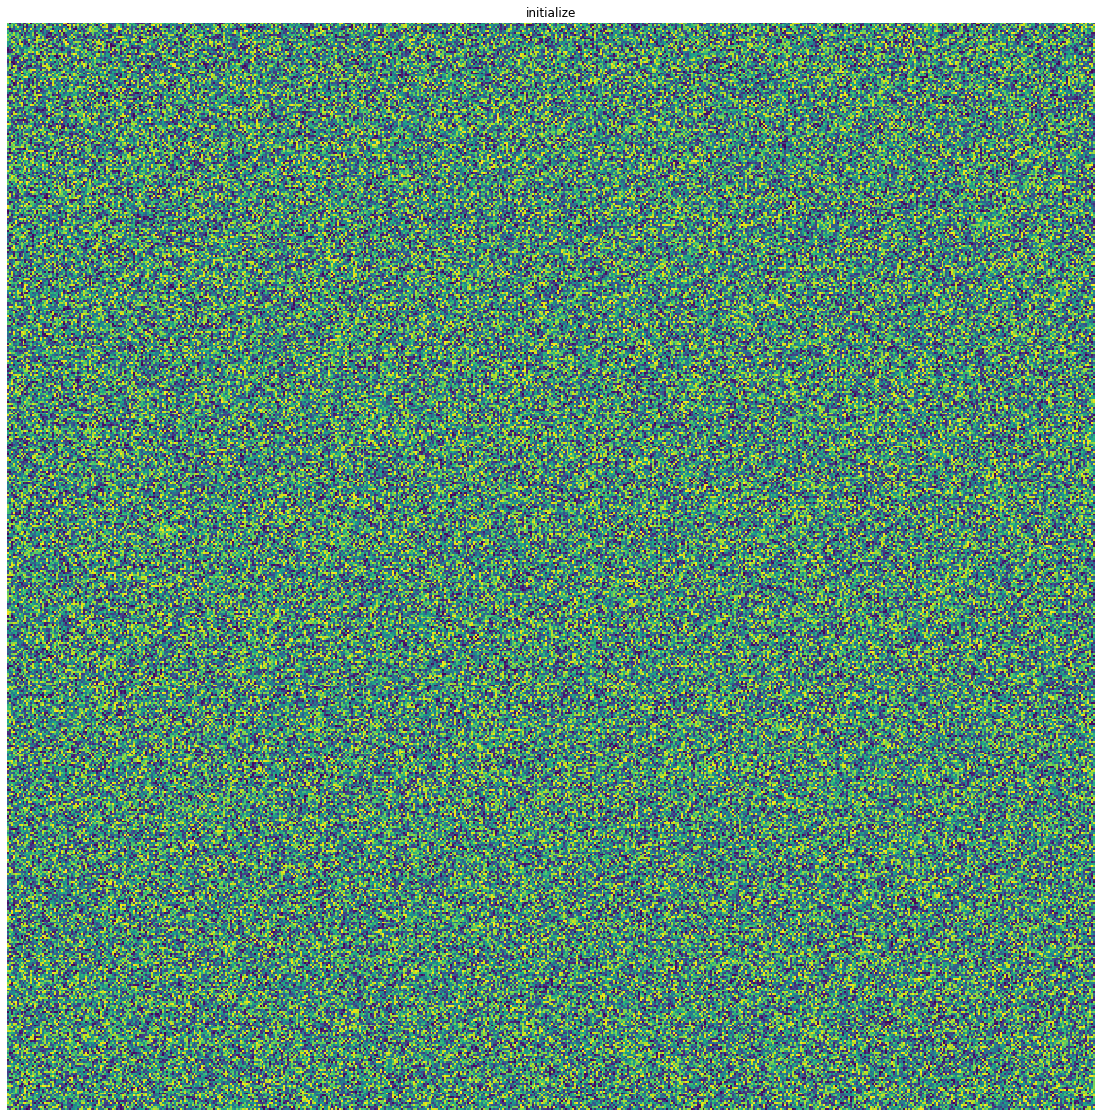

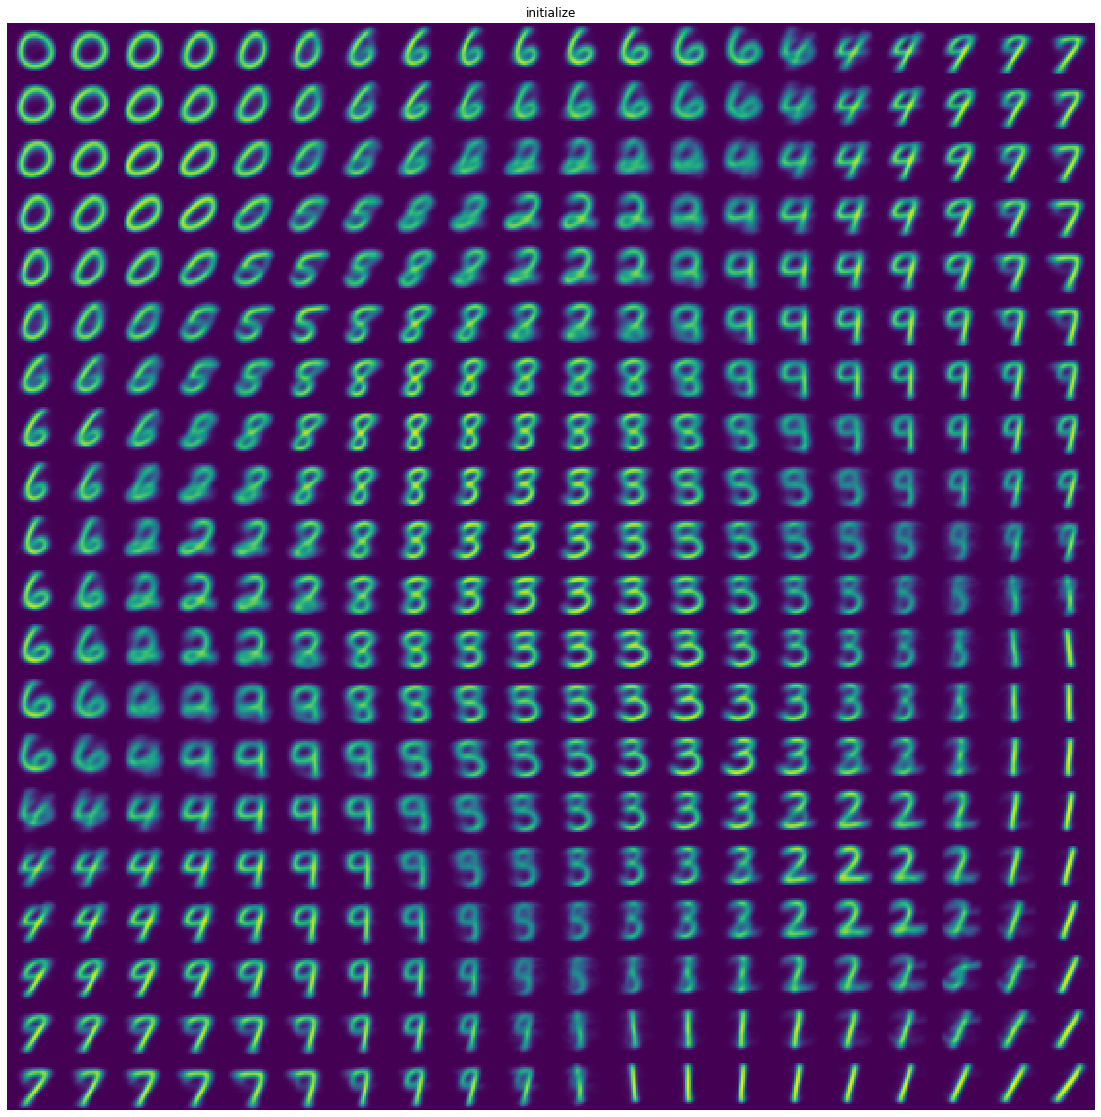

[INFO] It took 554.3939380645752 seconds


In [6]:
start = time.time()

map_image = create_grid_image(N, som.nodes, resolution=28)
plt.figure(figsize=(20,20))
plt.title('initialize')
plt.axis('off')
plt.imshow(map_image ,interpolation='none')
plt.show()

# Train
som.train()

map_image = create_grid_image(N, som.nodes, resolution=28)
plt.figure(figsize=(20,20))
plt.title('initialize')
plt.axis('off')
plt.imshow(map_image ,interpolation='none')
plt.show()



print("[INFO] It took {} seconds".format(time.time() - start))